# Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from os.path import join
from solver import Point, Facility, Customer, length, load_data
from vis import view_problem

In [3]:
path = 'data'
ls = os.listdir

In [4]:
# print(*ls(path),sep = '  ,  ')
for i,file in enumerate(ls(path)):
    customers, facilities = load_data(file)
    print(f'{file:15} {len(customers):6} Customers \t{len(facilities):6} Facilities')

fl_1000_2         1500 Customers 	  1000 Facilities
fl_1000_3         5000 Customers 	  1000 Facilities
fl_100_1          1000 Customers 	   100 Facilities
fl_100_10          100 Customers 	   100 Facilities
fl_100_11          500 Customers 	   100 Facilities
fl_100_12          500 Customers 	   100 Facilities
fl_100_13         1000 Customers 	   100 Facilities
fl_100_14          800 Customers 	   100 Facilities
fl_100_2          1000 Customers 	   100 Facilities
fl_100_3          1000 Customers 	   100 Facilities
fl_100_4          1000 Customers 	   100 Facilities
fl_100_5          1000 Customers 	   100 Facilities
fl_100_6           100 Customers 	   100 Facilities
fl_100_7           100 Customers 	   100 Facilities
fl_100_8           100 Customers 	   100 Facilities
fl_100_9           100 Customers 	   100 Facilities
fl_16_1             50 Customers 	    16 Facilities
fl_16_2             50 Customers 	    16 Facilities
fl_2000_2         2000 Customers 	  2000 Facilities
fl_2000_3   

In [137]:
customers, facilities = load_data('fl_100_7')
(customers, facilities)

([Customer(index=0, demand=2, location=Point(x=42.025527, y=33.616725)),
  Customer(index=1, demand=2, location=Point(x=41.980592, y=34.211489)),
  Customer(index=2, demand=4, location=Point(x=57.023391, y=34.309149)),
  Customer(index=3, demand=5, location=Point(x=3.657277, y=29.06113)),
  Customer(index=4, demand=3, location=Point(x=49.152254, y=36.213567)),
  Customer(index=5, demand=1, location=Point(x=33.925347, y=31.222968)),
  Customer(index=6, demand=5, location=Point(x=60.883163, y=42.991909)),
  Customer(index=7, demand=3, location=Point(x=49.793091, y=38.717563)),
  Customer(index=8, demand=4, location=Point(x=56.820527, y=36.707275)),
  Customer(index=9, demand=1, location=Point(x=34.301367, y=30.778683)),
  Customer(index=10, demand=1, location=Point(x=34.176174, y=31.355789)),
  Customer(index=11, demand=1, location=Point(x=34.23757, y=31.277996)),
  Customer(index=12, demand=2, location=Point(x=41.402673, y=34.168284)),
  Customer(index=13, demand=5, location=Point(x=60.

# Visualisation


In [5]:
from vis import view_problem, view_solution

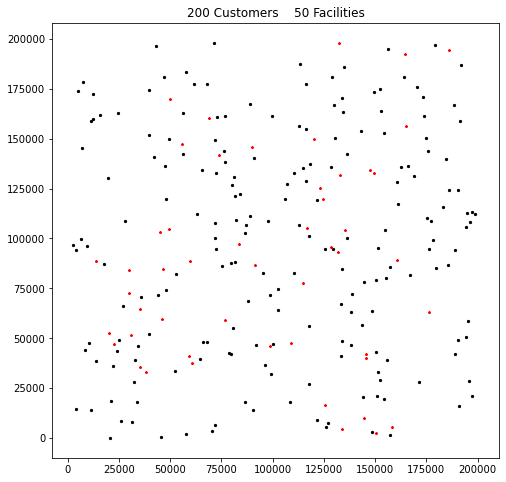

In [6]:
view_problem(customers,facilities)

In [139]:
sol = greedy(customers,facilities)

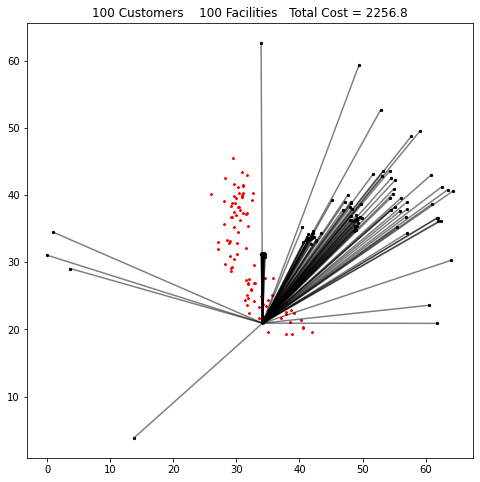

In [140]:
view_solution(sol,customers,facilities)

# Exploration

In [7]:
from calc import validate, total_cost

from algorithms import greedy
from exceptions import *

## Random allocation

In [48]:
from pdb import set_trace

In [117]:
from tqdm.auto import tqdm, trange


def random_allocation(customers, facilities):
    max_iter = 10000
    n_fac = len(facilities)
    allocations = -np.ones(len(customers))
    remaining_capacity = np.array([f.capacity for f in facilities])
    for i, customer in enumerate(customers):
        for counter in range(max_iter):
            selected_facility = np.random.choice(
                range(n_fac),
                p=remaining_capacity / remaining_capacity.sum(),
            )
            if remaining_capacity[selected_facility] >= customer.demand:
                remaining_capacity[selected_facility] -= customer.demand
                allocations[i] = selected_facility
                break
        else:
            raise IterationError('Maximum number of iterations reached.')
    return allocations.astype(int)


def local_search(solution, customers, facilities, verbose=False):
    allocations = solution.copy()
    n_cutomers = len(customers)
    n_facilities = len(facilities)
    old_cost = total_cost(allocations, customers, facilities)
    pbar = trange(n_cutomers)
    for i in pbar:
        customer = customers[i]
        costs = np.zeros(n_facilities)
        old_alloc = allocations[i]
        for j in range(n_facilities):
            allocations[i] = j
            costs[j] = total_cost(allocations, customers, facilities)
        new_alloc = np.argmin(costs)
        allocations[i] = new_alloc
        if verbose:
            desc = '{:.1f} --> {:.1f} --> {:.1f}'.format(
                old_cost,
                costs[old_alloc],
                costs[new_alloc],
            )
            pbar.set_description(desc)
    return allocations

In [133]:
sol = random_allocation(customers,facilities)
total_cost(sol,customers,facilities)

109775306.1991202

In [134]:
sol2 = local_search(sol,customers,facilities,True)

In [135]:
sol = greedy(customers,facilities)
total_cost(sol,customers,facilities)

26090682.612702664

In [136]:
sol2 = local_search(sol,customers,facilities,True)

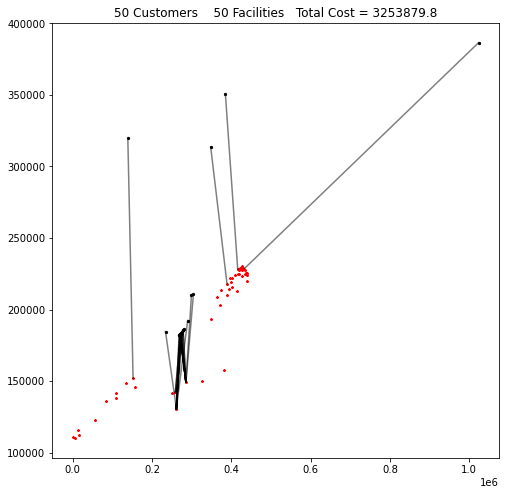

In [88]:
view_solution(sol2,customers,facilities)

In [141]:
validate(sol2,customers,facilities)

IndexError: list index out of range

## Constraint Programming

### Uncapacitated Facilities

In [174]:
from ortools.sat.python import cp_model
from calc import distance_matrix


In [146]:
customers,facilities= load_data('fl_100_1')
n_cust = len(customers)
n_fac = len(facilities)

In [164]:
caps = [f.capacity for f in facilities]
setup = [f.setup_cost for f in facilities]
dist = distance_matrix(customers,facilities).astype(int)
demands = [c.demand for c in customers]

In [147]:
model = cp_model.CpModel()

In [157]:
a = [] # allocation matrix (facilities x customers)
for f in range(n_fac):
    a.append([model.NewBoolVar(f'a_{c}_{f}') for c in range(n_cust)])

In [161]:
# Only one facility per customer
for c in range(n_cust):
    model.Add(sum([a[f][c] for f in range(n_fac)])==1)
    
# Capacity check
for f in range(n_fac):
    model.Add(sum([a[f][c]*demands[c] for c in range(n_cust)])<=caps[f])

In [165]:
obj = 0
for f in range(n_fac):
    for c in range(n_cust):
        obj+=a[f][c]*dist[f,c]

In [169]:
model.Minimize(obj)

In [170]:
cpsolver = cp_model.CpSolver()
cpsolver.parameters.max_time_in_seconds = 60.0
status = cpsolver.Solve(model)

In [175]:
STATUS = {
    cp_model.FEASIBLE: 'FEASIBLE',
    cp_model.UNKNOWN: 'UNKNOWN',
    cp_model.MODEL_INVALID: 'MODEL_INVALID',
    cp_model.INFEASIBLE: 'INFEASIBLE',
    cp_model.OPTIMAL: 'OPTIMAL',
}
STATUS[status]

'FEASIBLE'

In [176]:
values = [] # allocation matrix (facilities x customers)
for f in range(n_fac):
    values.append([cpsolver.Value(a[f][c]) for c in range(n_cust)])

values = np.array(values)

sol = values.argmax(axis=0)

In [183]:
total_cost(sol,customers,facilities)

135235944.1211516

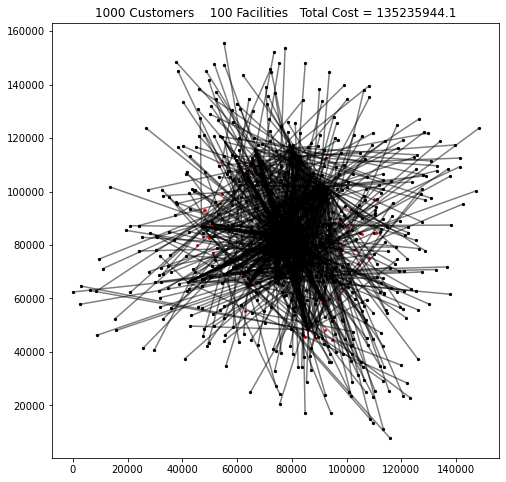

In [184]:
view_solution(sol,customers,facilities)

## Solve for set number of facilities

In [132]:
import math
from sklearn.cluster import KMeans
from sklearn.neighbors import KDTree
from calc import total_demand, total_cost
from tqdm.auto import trange

In [115]:
q = [2,3,5,3,1]

In [118]:
np.cumsum(sorted(q))

array([ 1,  3,  6,  9, 14], dtype=int32)

In [123]:
def min_facilities(customers, facilities):
    caps = [f.capacity for f in facilities]
    cumsum = np.cumsum(sorted(caps))
    demands = [c.demand for c in customers]
    total_demand = sum(demands)
    for i in range(len(facilities)):
        if cumsum[i]>=total_demand:
            print(f'Demand = {total_demand}, Capacity = {cumsum[i]}')
            return i+1
    
#     return math.ceil(total_demand/max(caps))

In [124]:
min_facilities(customers,facilities)

Demand = 50886, Capacity = 56000


7

In [74]:
customers, facilities = load_data('fl_100_1')
n_cust = len(customers)
n_fac = len(facilities)
n_cust,n_fac

(1000, 100)

In [75]:
# total_demand(customers)

In [76]:
# [f.capacity for f in facilities]

In [140]:
def clustering(customers, facilities):
    n_cust = len(customers)
    n_fac = len(facilities)
    
    # Find minimum number of clusters
    min_fac = min_facilities(customers,facilities)
    
    # Find cluster centroids
    kmean = KMeans(min_fac)
    xy = np.array([c.location for c in customers])
    kmean.fit(xy)
    centroids = kmean.cluster_centers_
    
    # Find the distance between facilities and centroids
    fneigh = KDTree(np.array([f.location for f in facilities]))
    dist, locs = fneigh.query(centroids,min_fac)
    
    # Match facilities with centroids
    inactive_facs = set(range(n_fac))
    active_facs = []
    for i in range(min_fac):
        for j in range(min_fac):
            if locs[i,j] in inactive_facs:
                inactive_facs = inactive_facs - {locs[i,j]}
                active_facs.append(locs[i,j])
                break
    
    # Assign facilities to customers
    turn = 0
    remaining_cap = [facilities[f].capacity for f in active_facs]
    remaining_cust = set(range(n_cust))
    max_iter = len(active_facs)*n_cust
    sol = -np.ones(n_cust,dtype=int)
    pbar = trange(n_cust)
    for _ in range(max_iter):
        turn +=1
        turn %=len(active_facs)
        turn_fac = active_facs[turn]
        kd_cust = KDTree(np.array([customers[c].location for c in list(remaining_cust)]))
        dist, pot_cust = kd_cust.query([facilities[turn_fac].location],1)
        pot_cust = list(remaining_cust)[pot_cust[0][0]]
        if remaining_cap[turn]<customers[pot_cust].demand:
            continue
        else:
            pbar.update()
            sol[pot_cust] = turn_fac
            remaining_cust = remaining_cust - {pot_cust}
            remaining_cap[turn]-=customers[pot_cust].demand
        if min(sol)>=0:
            break
    else:
        IterationError('Maximum number of iteration reached.')
    return sol

In [141]:
sol = clustering(customers,facilities)

Demand = 50886, Capacity = 56000


In [142]:
sol

array([80, 91, 24, 66, 80, 24, 51, 38, 38, 91, 91, 80, 80, 80, 27, 51, 38,
       80, 80, 91, 24, 80, 66, 80, 80, 80, 66, 51, 24, 38, 51, 91, 80, 91,
       27, 24, 27, 38, 51, 66, 27, 80, 24, 51, 66, 51, 24, 27, 27, 38, 51,
       80, 51, 24, 80, 80, 51, 91, 91, 24, 27, 38, 91, 38, 66, 27, 51, 27,
       51, 91, 27, 38, 24, 27, 27, 51, 91, 38, 51, 27, 38, 80, 24, 80, 24,
       66, 66, 66, 24, 51, 51, 24, 80, 91, 80, 27, 66, 38, 80, 51, 24, 80,
       51, 80, 51, 38, 27, 80, 91, 80, 24, 24, 38, 66, 51, 27, 51, 66, 51,
       80, 91, 38, 24, 38, 24, 91, 66, 27, 51, 24, 27, 66, 27, 80, 24, 38,
       51, 24, 27, 80, 51, 66, 24, 80, 91, 66, 91, 24, 80, 51, 91, 24, 38,
       38, 51, 80, 38, 51, 27, 80, 66, 38, 24, 27, 66, 80, 24, 80, 80, 38,
       24, 27, 38, 91, 38, 24, 38, 66, 24, 80, 27, 24, 24, 66, 38, 91, 38,
       66, 38, 38, 24, 27, 91, 91, 51, 51, 66, 38, 38, 51, 51, 51, 80, 24,
       66, 24, 91, 27, 66, 38, 51, 91, 51, 51, 80, 91, 80, 91, 80, 91, 66,
       66, 66, 27, 38, 51

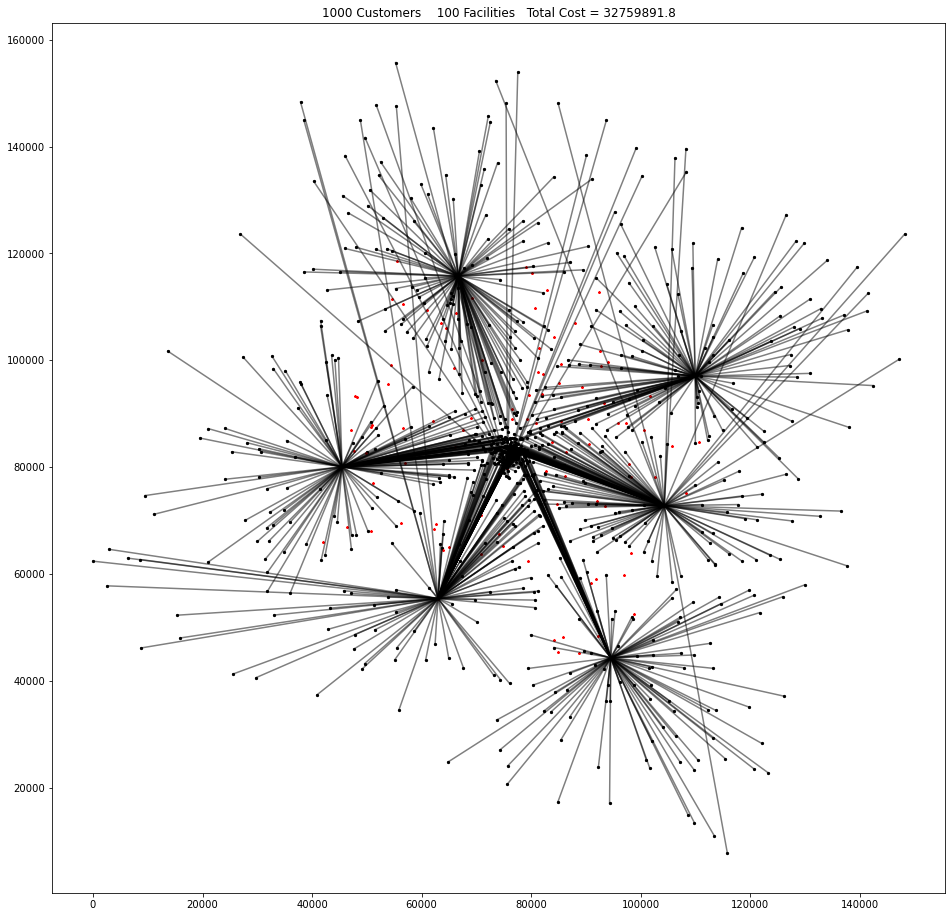

In [144]:
view_solution(sol,customers,facilities,(16,16))